In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

plt.style.use("fivethirtyeight")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
    
)
plt.rc(
    "lines",
    linewidth = 2
)
%config InlineBackend.figure_format = 'retina'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Import the data

In [2]:
oil_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holiday_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
transactions_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [3]:
store_sales = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales_data = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [4]:
holiday_events = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv',
    usecols=['date', 'locale_name'],
    dtype={
        'local_name': 'category',
    },
    parse_dates=['date']
)
holiday_events = holiday_events.set_index('date')

In [5]:
print(f'Train data dimensions: {store_sales.shape}')

Train data dimensions: (3000888, 1)


# Create a pivot table to divide sales by store

In [6]:
sales_per_store = pivot_table = pd.pivot_table(store_sales, values='sales', index='date', columns=['store_nbr'],aggfunc="sum", observed=False)

# A Sample time series to start modeling

<Axes: xlabel='date'>

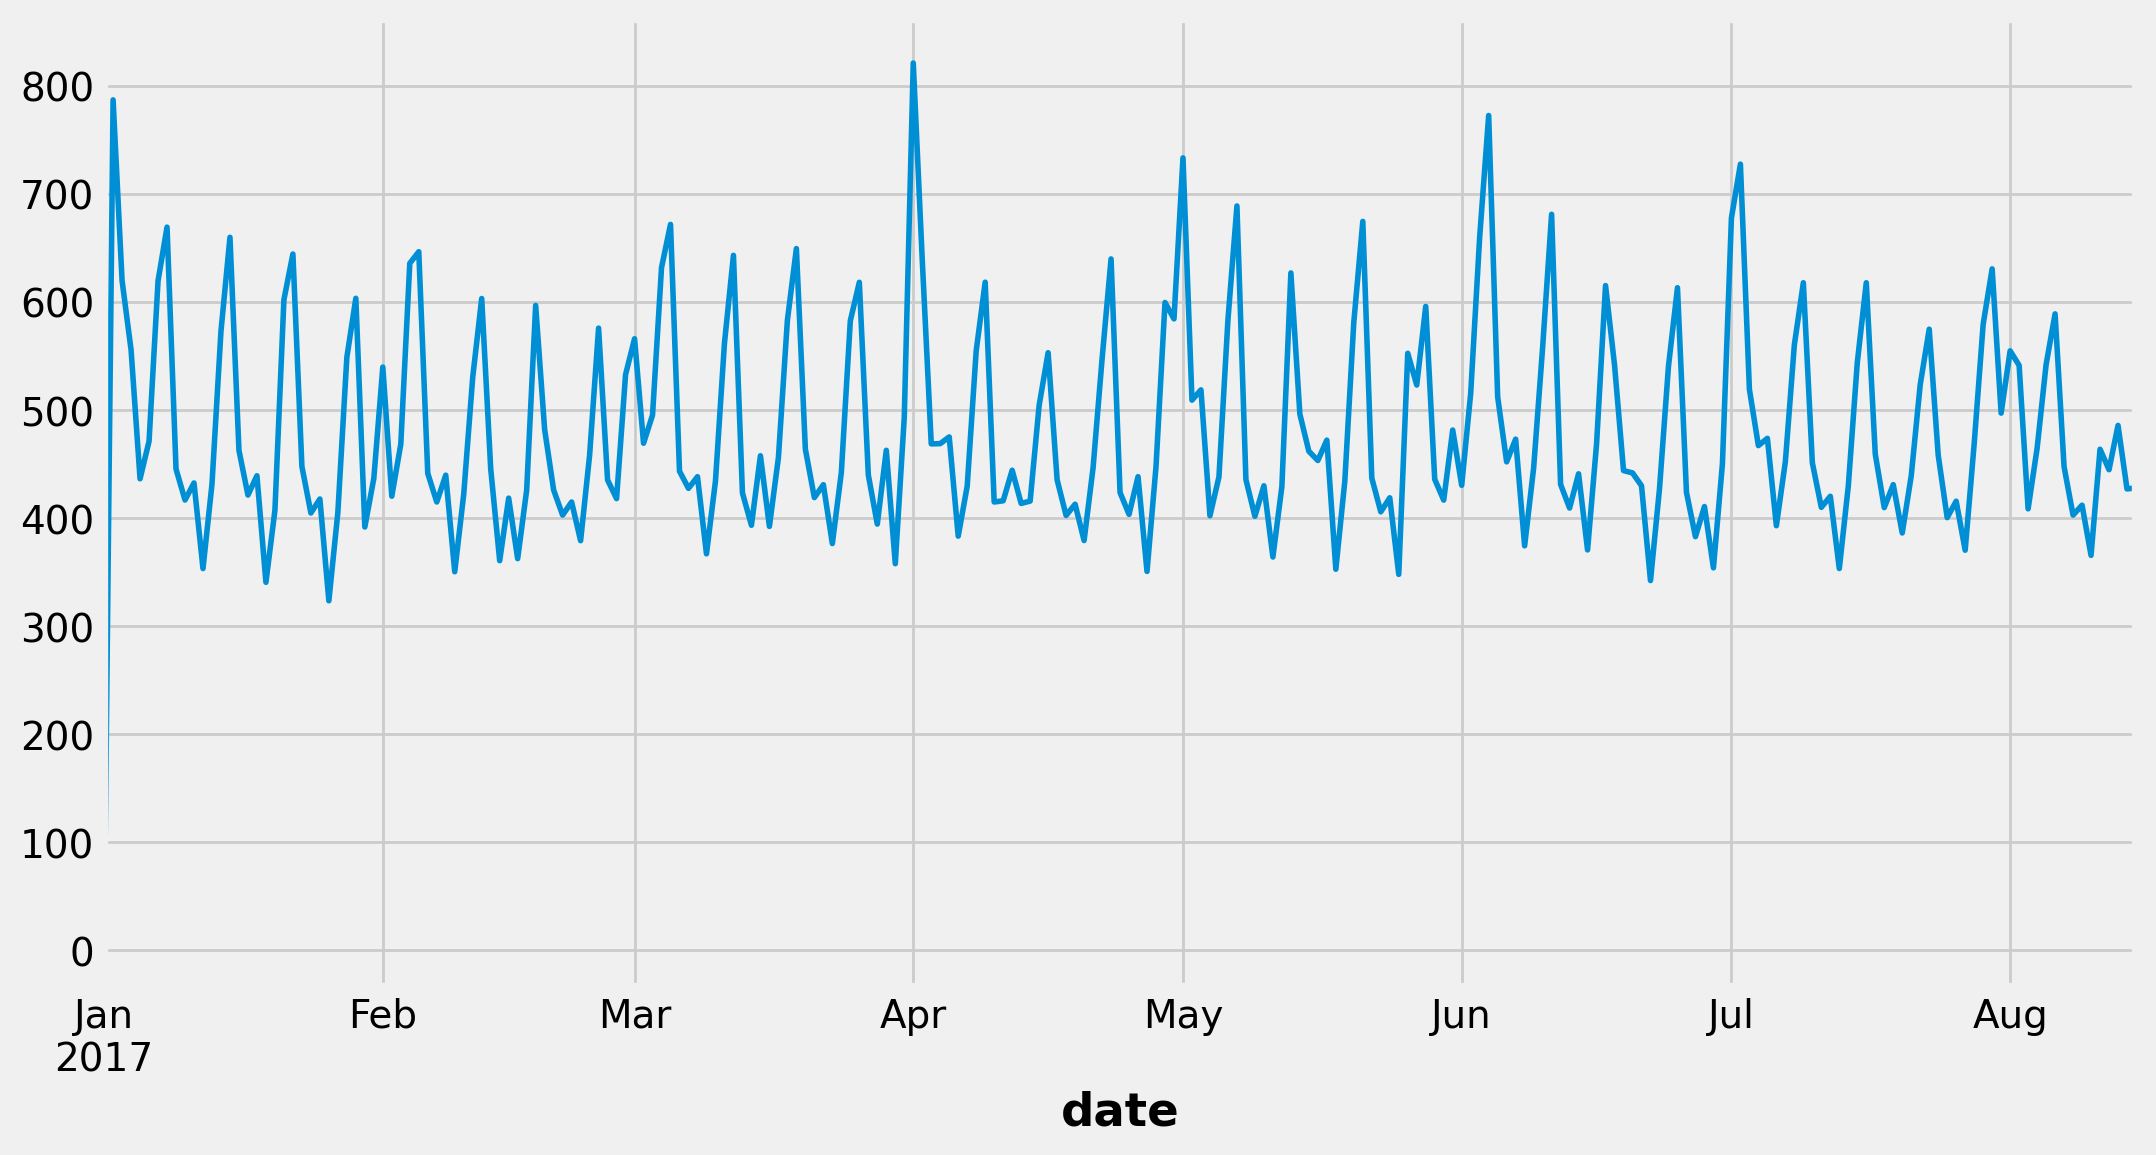

In [7]:
average_sales = average_sales_data.to_frame()
average_sales['sales'].plot()

# Create a deterministic process to make trend

In [8]:
dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
date,,
2017-01-01,1.0,1.0
2017-01-02,1.0,2.0
2017-01-03,1.0,3.0
2017-01-04,1.0,4.0
2017-01-05,1.0,5.0


In [9]:
model = LinearRegression(fit_intercept=False)
model.fit(X, average_sales['sales'])

y_pred = pd.Series(model.predict(X), index=X.index)

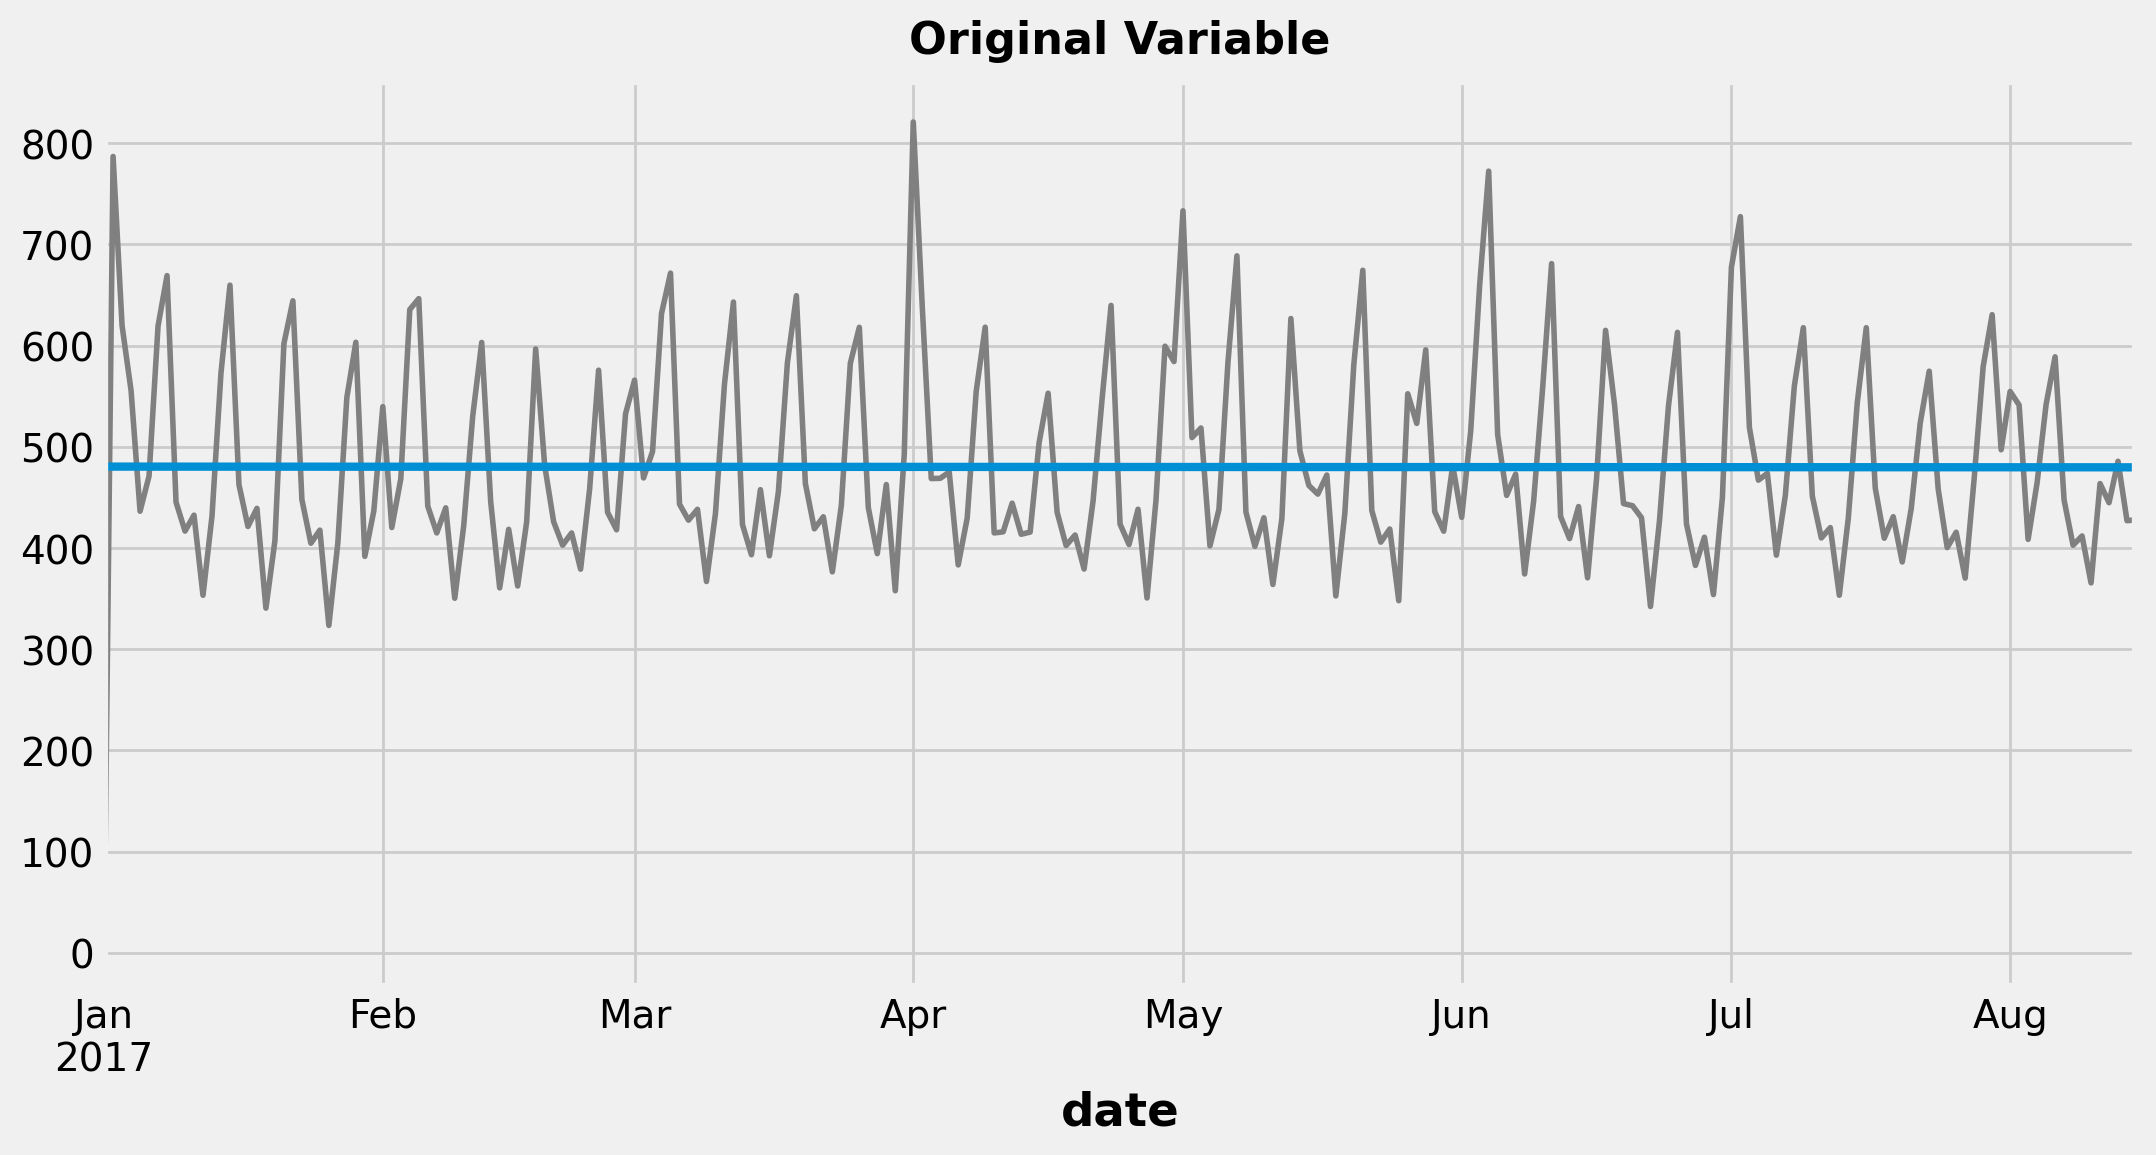

In [10]:
ax = average_sales['sales'].plot(style="-", color="0.5", title="Original Variable")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

# Predict with the most basic model: Trend

In [11]:
X_fore = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
y_fore.head()

2017-08-16    479.770285
2017-08-17    479.767178
2017-08-18    479.764071
2017-08-19    479.760964
2017-08-20    479.757857
Freq: D, dtype: float64

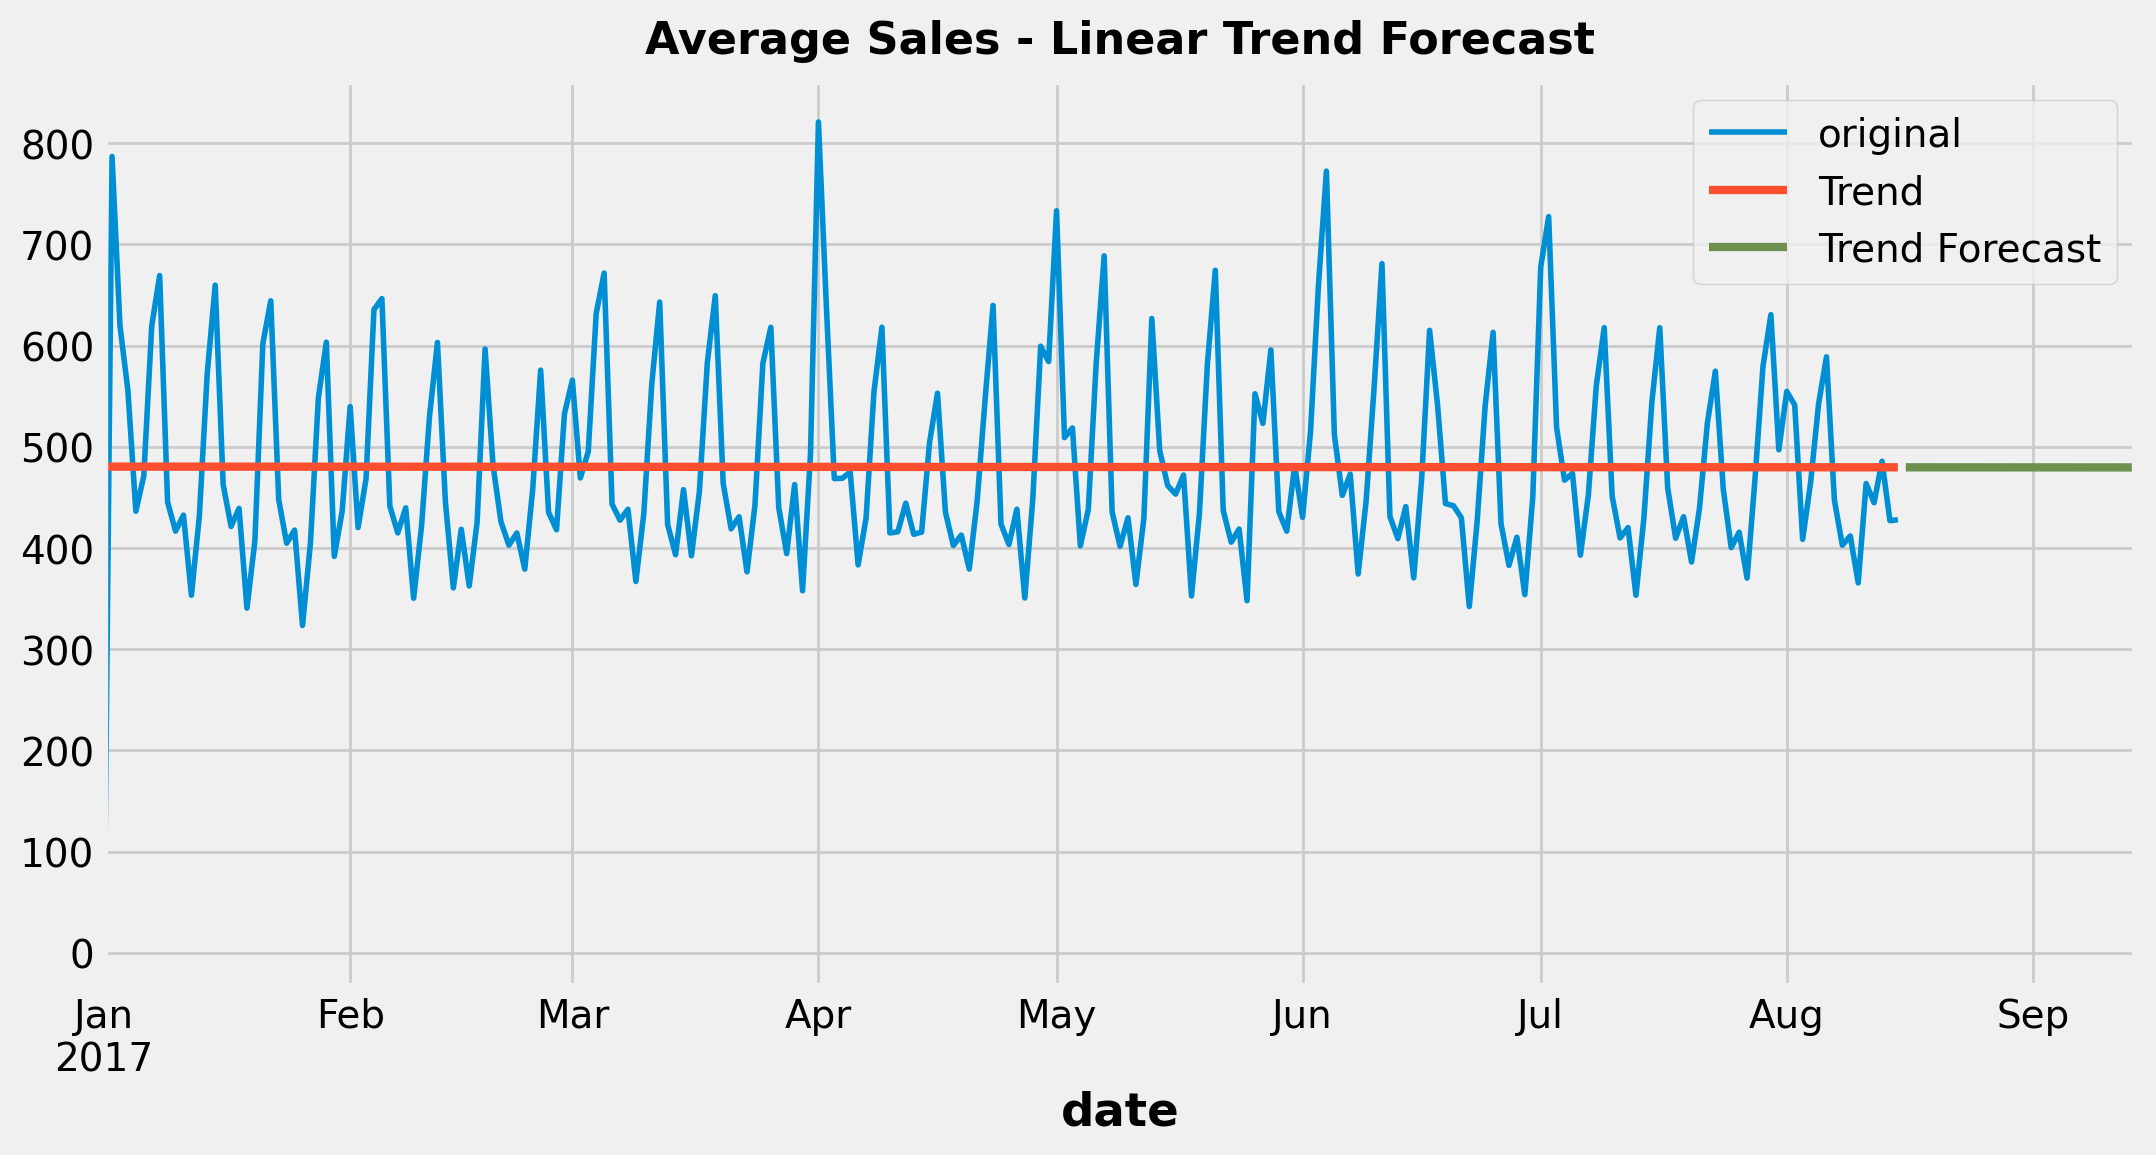

In [12]:
ax = average_sales['sales'].plot(title="Average Sales - Linear Trend Forecast", label='original')
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

# Seasonality

In [13]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [14]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: Futu

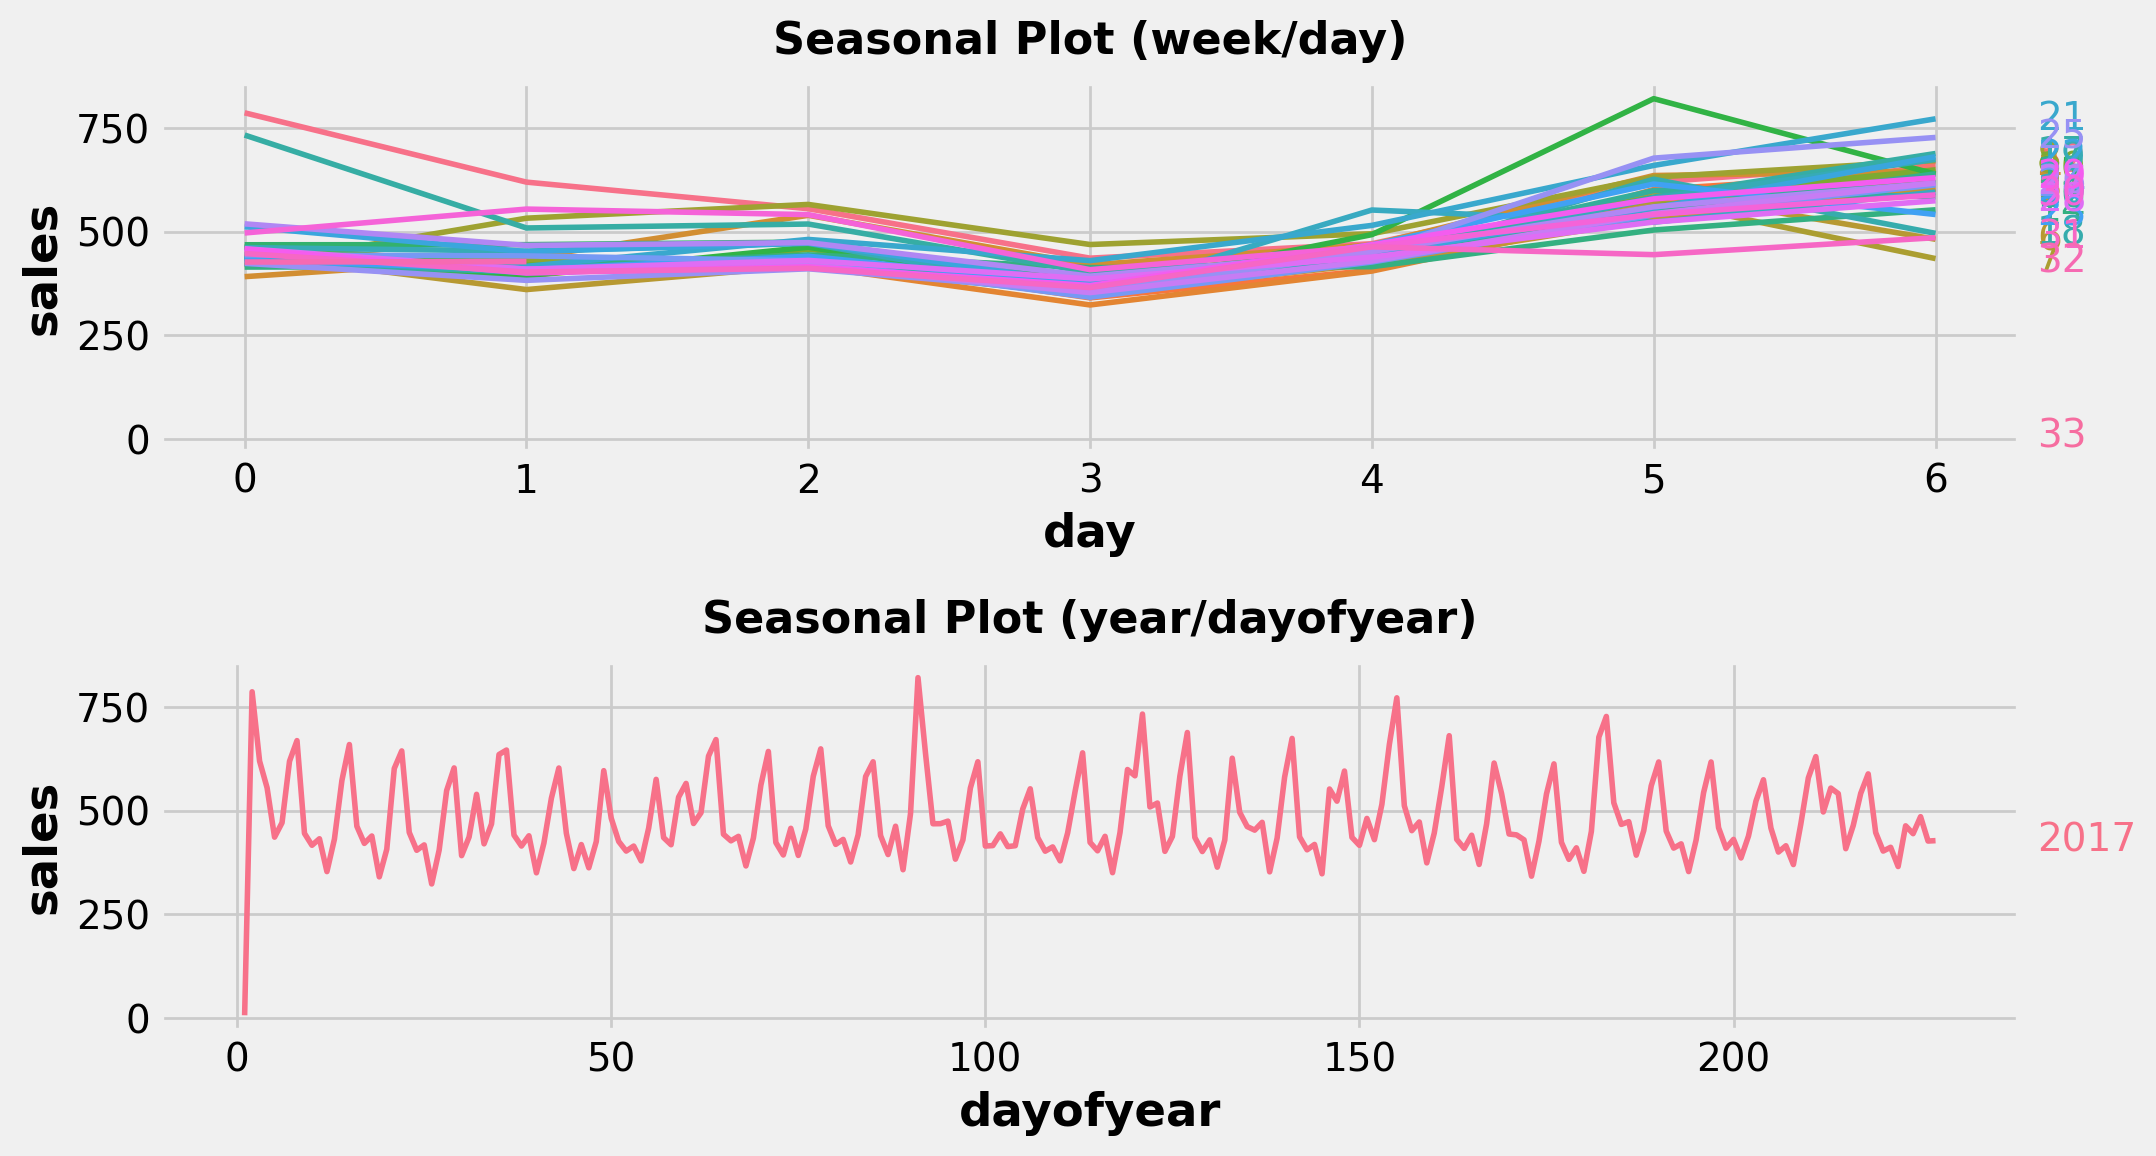

In [15]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


X = average_sales.copy()

X = X.replace([np.inf, -np.inf], np.nan)

# days within a week
X["day"] = average_sales.index.dayofweek  # the x-axis (freq)
X["week"] = average_sales.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = average_sales.index.dayofyear
X["year"] = average_sales.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

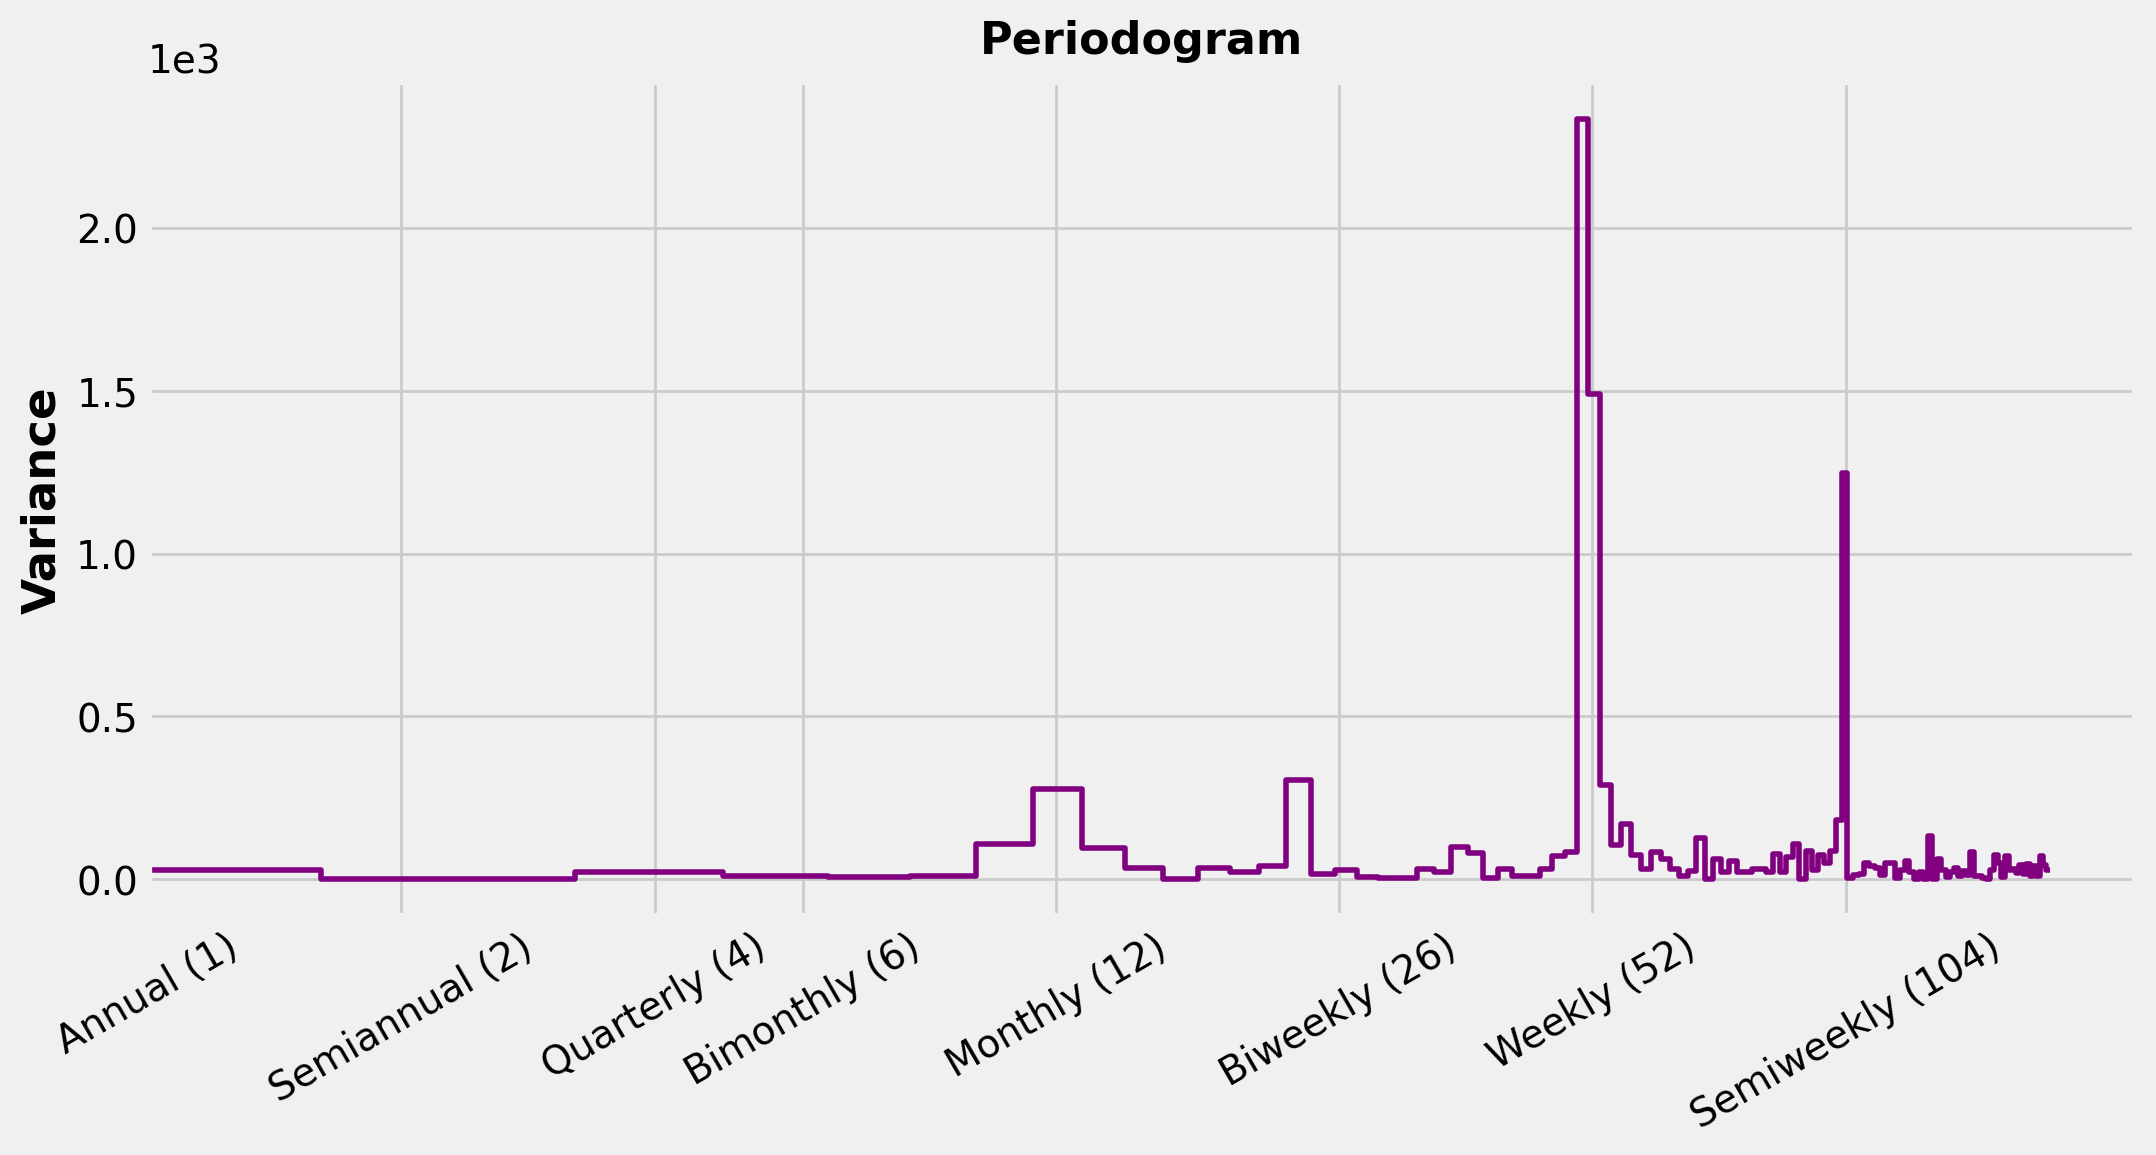

In [16]:
plot_periodogram(average_sales.sales)

In [17]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="ME", order=1) 

dp = DeterministicProcess(
    index=average_sales.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)"
date,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967


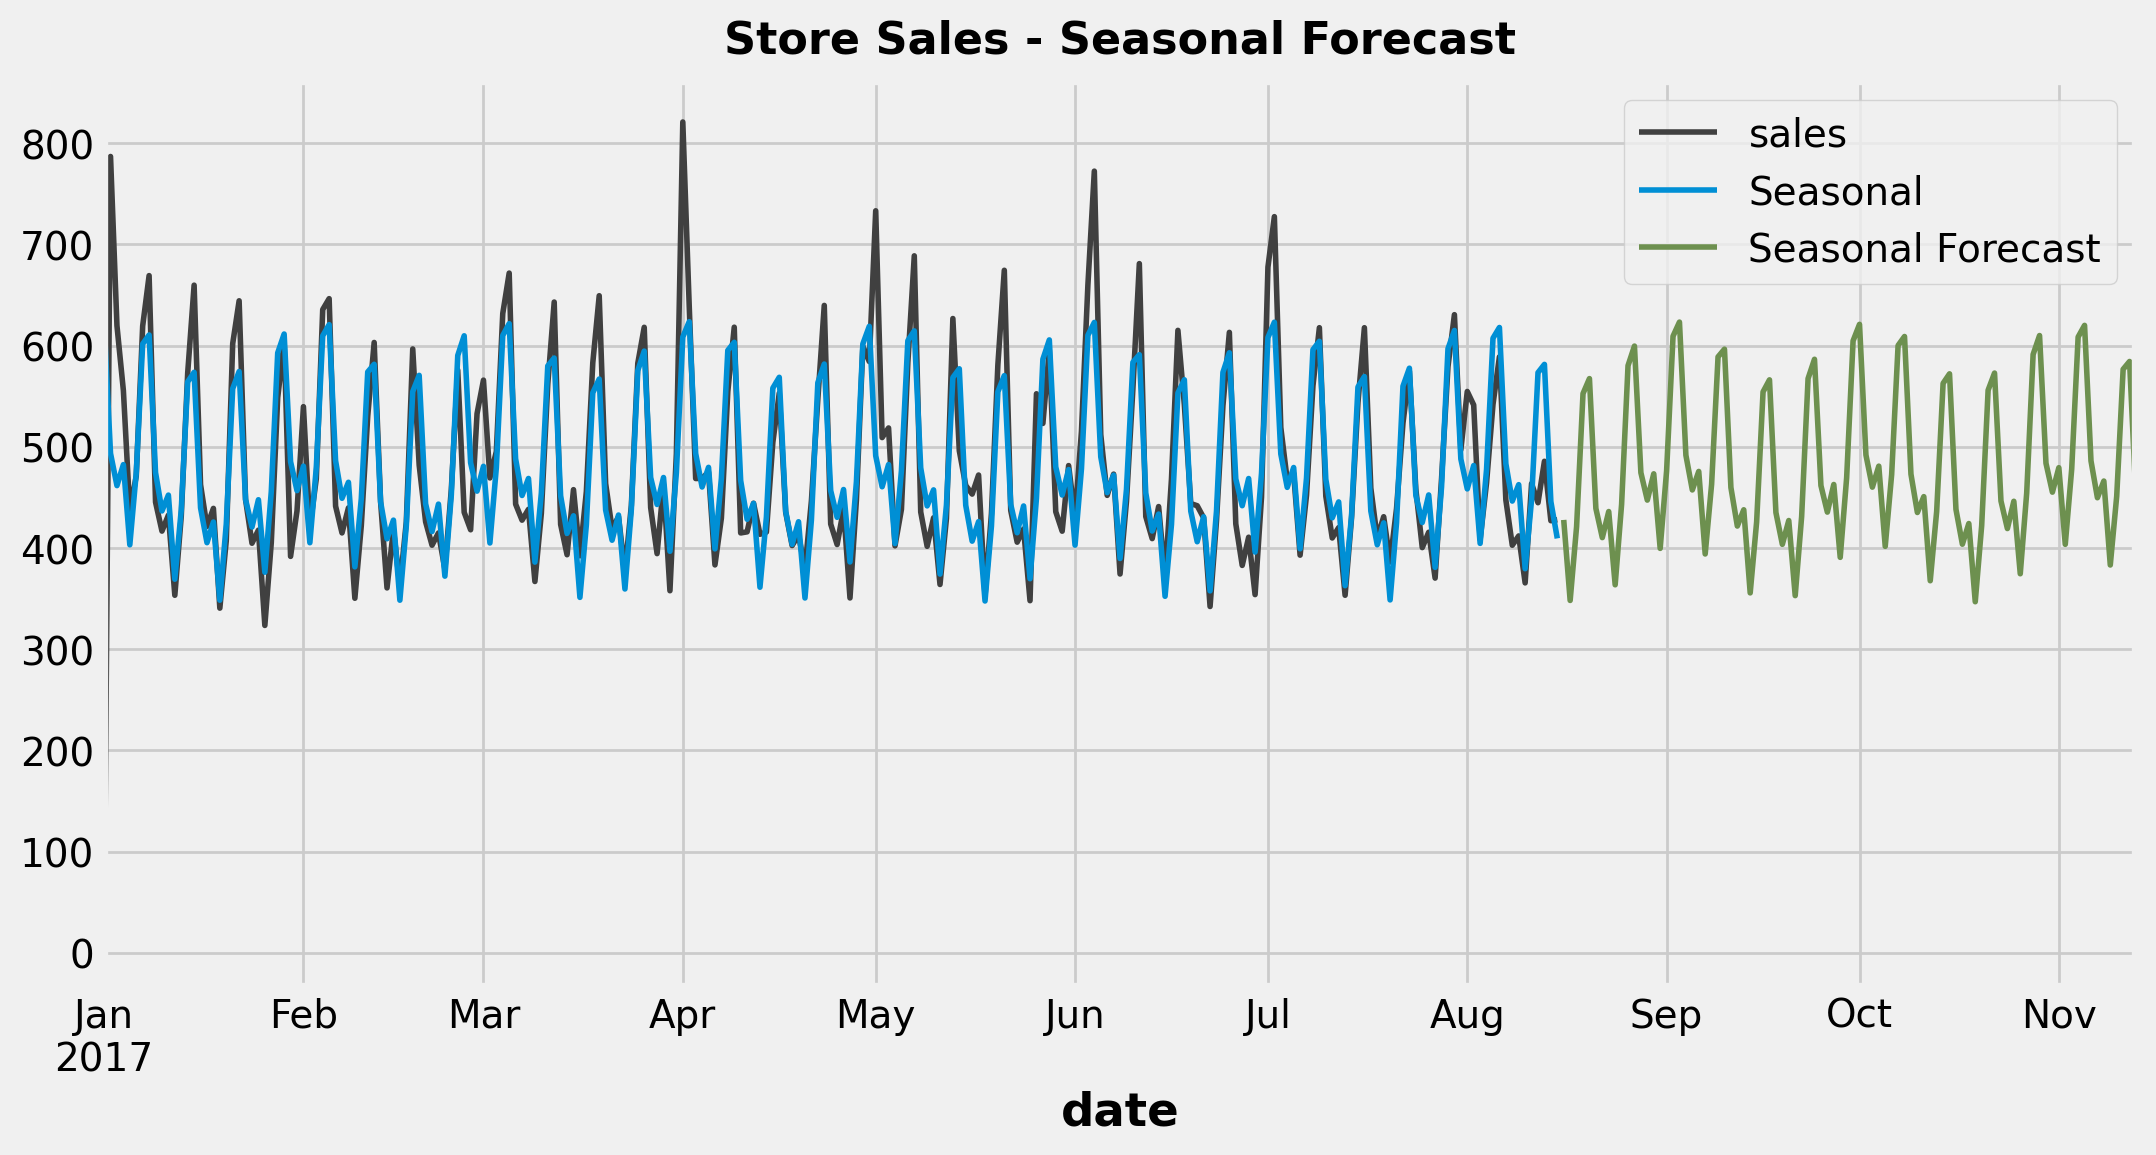

In [18]:
y = average_sales["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)


y_pred = pd.Series(model.predict(X), index=y.index)

X_fore = dp.out_of_sample(steps=90)

y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='-', title="Store Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

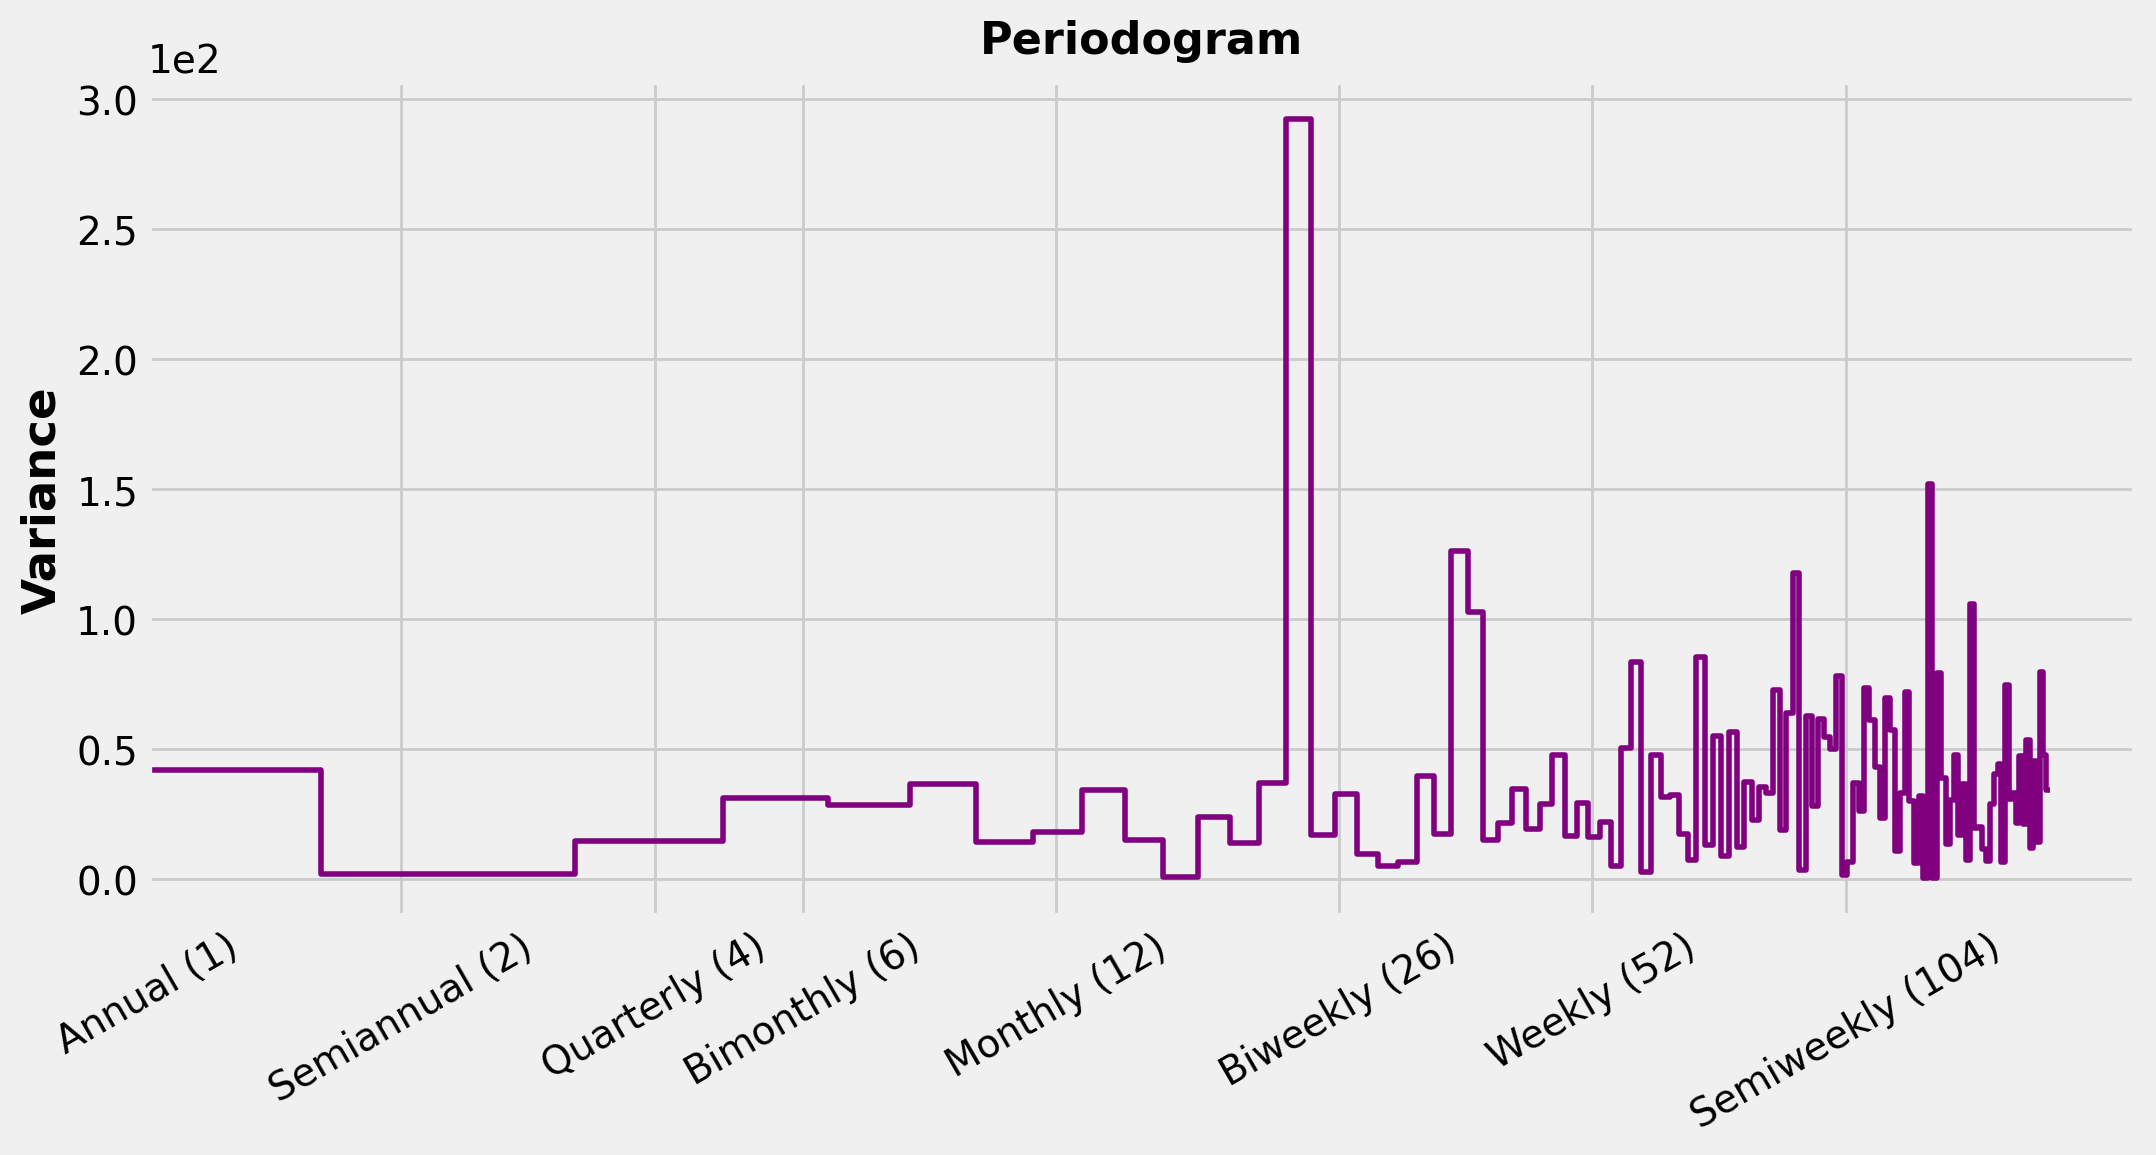

In [19]:
y_deseason = y - y_pred
plot_periodogram(y_deseason)

In [20]:
X_copy = X.copy()
X['fecha'] = X_copy.index.to_timestamp()
holiday_events['fecha'] = holiday_events.index.to_period('D').to_timestamp()

X = X.reset_index().merge(holiday_events, how="left", on=["fecha", "fecha"]).set_index('date')

In [21]:
X = X.assign(festivity = np.where(X['locale_name'].notna(), 1, 0))
X = X.drop(columns=['locale_name', 'fecha'])
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)",festivity
date,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,1
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0
